In [1]:
!which python
%reset -f
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from IPython.display import display, Image
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns
import pandas as pd
import networkx as nx
import os.path
import pylab

/usr/bin/python


In [2]:
from sklearn.ensemble import GradientBoostingClassifier
threshold = 10
rarifaction = 5000
minimum_number_koalas = 3
level_taxonomy = "g__"
taxonomy_level_integer = -2
edge_threshold= 20 
threshold_number_occur_samples = 0
#koalas2keep = ['A'] ->rad
koalas2keep = ['J','B', 'F','P', 'E', 'G','R', 'A', 'D','H', 'K'] #, k

In [3]:
 """ This cell needs to be executed only once to convert biome table into txt file table including taxonomy"""
# !biom convert -i '/Users/Lily/Desktop/Koala/OpenReferece_Final/OTUs_No_Euks_unassigned_filtered_out_with_metadata.biom' -o table.from_biom_w_taxonomy.txt --to-tsv --header-key taxonomy
# !tail -n +2 '/Users/Lily/Desktop/Koala/table.from_biom_w_taxonomy.txt' > 'open_reference_koala_table.txt'
None

In [4]:
Koala = pd.read_table('/Users/Lily/Desktop/Koala/open_reference_koala_table.txt', sep='\t', header='infer')

In [5]:
print Koala.shape
Koala['#OTU ID'] = [str(x) for x in Koala['#OTU ID']]
Koala.head()

(21432, 174)


,#OTU ID,T20,E2,T9,T8,T17,T14,T13,D2,K3,...,C4,NEG.BLANK,C1,C3.2,F5.2,NEG.H20,T7,T6,T2,taxonomy
0,185100,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,k__Bacteria; p__Proteobacteria; c__Deltaproteo...
1,741867,0.0,1.0,37.0,17.0,4.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,k__Bacteria; p__Actinobacteria; c__Actinobacte...
2,562114,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,k__Bacteria; p__Proteobacteria; c__Alphaproteo...
3,511346,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,k__Bacteria; p__Bacteroidetes; c__[Saprospirae...
4,253429,0.0,0.0,6.0,0.0,8.0,0.0,0.0,1.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,k__Bacteria; p__Bacteroidetes; c__Flavobacteri...


In [6]:
"""Functions needed for OTUs tat need to be merged by genus level"""

def get_index_genus(array,lt=level_taxonomy):
    for i in array:
        if i.find(lt) != -1:
            return array.index(i), i
    return False, False
    
def add_two_lists(l1,l2):
    result = []
    for i in range(len(l1)):
        result.append(l1[i]+l2[i])
    return result


In [7]:
"""OTUs need to be merged at this point by genus level"""
#"""
htb_merge_taxonomy = {}
htb_merge_taxonomy_real_taxonomy = {}
htb_merge_taxonomy_values = {}

for index, otus_row in Koala.iterrows():

    all_taxonomy = otus_row['taxonomy']
    array_taxonomy = str(otus_row['taxonomy']).split(";") #there should be 6 elements in this array
    genus_index,value = get_index_genus(array_taxonomy)
    if genus_index!=False:        
        if value in htb_merge_taxonomy: #this is genus
            htb_merge_taxonomy[value].append(otus_row['#OTU ID'] )
            vector = otus_row.tolist()[1:-1]
            htb_merge_taxonomy_values[value] = add_two_lists(htb_merge_taxonomy_values[value],vector) #merging means sum up the abundances
            if len(list(all_taxonomy)) > htb_merge_taxonomy_real_taxonomy[value][1]:
                htb_merge_taxonomy_real_taxonomy[value] = [all_taxonomy,len(list(all_taxonomy))]
        else:
            htb_merge_taxonomy[value]=[otus_row['#OTU ID']]
            htb_merge_taxonomy_values[value] = otus_row.tolist()[1:-1] #this is vector
            htb_merge_taxonomy_real_taxonomy[value] = [all_taxonomy,len(list(all_taxonomy )) ]
#"""        

In [8]:
"""OTUs that were merged by genus will be deleted and instead the consensus will be there"""

#"""
for i in htb_merge_taxonomy:
    listrows2delete = htb_merge_taxonomy[i]
    if len(listrows2delete)>1:

        Koala = Koala[~Koala['#OTU ID'].isin(listrows2delete)]
        new_name = "-".join([str(x) for x in listrows2delete])    
        new_row = [new_name]+htb_merge_taxonomy_values[i] + [htb_merge_taxonomy_real_taxonomy[i][0]]
        Koala.loc[-1]=new_row
        Koala.index = Koala.index + 1
    
    

print Koala.shape    
Koala = Koala.sort()
Koala.head()
#"""

(2630, 174)


,#OTU ID,T20,E2,T9,T8,T17,T14,T13,D2,K3,...,C4,NEG.BLANK,C1,C3.2,F5.2,NEG.H20,T7,T6,T2,taxonomy
0,342283-346293,0.0,0.0,5.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,k__Bacteria; p__Proteobacteria; c__Betaproteob...
1,356574-4376154-4407475-161011-538111-New.Clean...,2.0,0.0,3.0,3.0,12.0,31.0,15.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,k__Bacteria; p__Actinobacteria; c__Actinobacte...
2,587540-365415,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,k__Bacteria; p__Proteobacteria; c__Gammaproteo...
3,660099-564437-4465803-237021-1075307-676761-25...,4.0,57.0,0.0,3.0,37.0,4.0,5.0,21.0,1.0,...,1.0,0.0,4.0,4.0,1.0,1.0,0.0,0.0,0.0,k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...
4,547579-New.CleanUp.ReferenceOTU39316,1.0,0.0,0.0,0.0,0.0,2.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,k__Bacteria; p__Chlamydiae; c__Chlamydiia; o__...


smallest number of reads in a sample =  5775.0
(2630, 174)
(2630, 156)


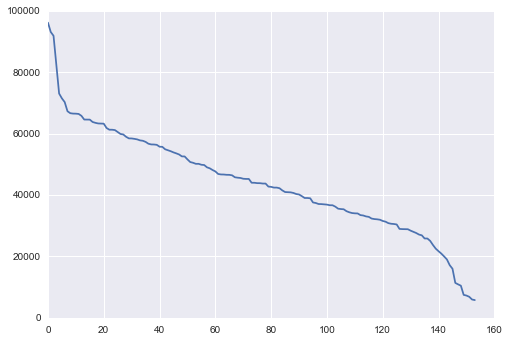

In [9]:
""" Some of the samples have low read counts in them, so I am removing those - rarefaction"""
list_col = Koala.columns.tolist()
list_col.remove('#OTU ID')
list_col.remove('taxonomy')
tmp = []
delete_columns_rarefy = []
for tmp_col in list_col:
    
    if sum(Koala[tmp_col])<rarifaction:
        delete_columns_rarefy.append(tmp_col)
#        print tmp_col, sum(Koala[tmp_col])
    else:
        tmp.append( sum(Koala[tmp_col]))
tmp.sort(reverse=True)
print "smallest number of reads in a sample = ", tmp[-1]
plt.plot(tmp)

print Koala.shape
Koala.drop(delete_columns_rarefy, axis=1, inplace=True)
print Koala.shape

In [10]:
Koala.shape

(2630, 156)

In [11]:
#Koala.to_csv("Koala_merged.csv", delimit="\t")

In [12]:
""" Have a mapping file for index and OTUIDs. If this file exists, use it instead."""
Koala['OTU_Mapping'] = range(Koala.shape[0])
df_OTU_Mapping = Koala[['#OTU ID','OTU_Mapping']]

OTUMapping_microbes = {}
fname = 'OTUMapping_microbes.txt'
if not os.path.isfile(fname):
    OTUMapping_file = open(fname,"wb")
    for index,value in df_OTU_Mapping.iterrows():
        OTUMapping_microbes[ str(value['OTU_Mapping'])] = str(value['#OTU ID'])
        OTUMapping_file.write("%s\t%s\n" %(value['OTU_Mapping'],value['#OTU ID'] ) )
        OTUMapping_file.flush()
    OTUMapping_file.close()
else:
    print "File already existed!"
    with open(fname,"rb") as f:
        for line in f:
            arr = line.strip().split("\t")
            OTUMapping_microbes[str(arr[0])]= str(arr[1])
    print "%s mappings were read\n" %len(OTUMapping_microbes.keys())
    f.close()
            

In [13]:
""" The name of the koala and the time point is added as a column name.
"""

df_taxonomy_otus = Koala[['#OTU ID','taxonomy']]
Koala.drop(['#OTU ID','taxonomy','OTU_Mapping'], axis=1, inplace=True)

new_column_names = []
col2drop = []

print Koala.columns[:5]
for col in Koala.columns:
    i = list(col)
    if str(i[0]) in koalas2keep:
        new_i = str(i[0]) + "_" + str(''.join(i[1:]))
        new_column_names.append(new_i)
#        abunances = Koala[col].tolist()
#         total_sum = sum(abunances)
#         Koala[col] = [value_abundance/total_sum for value_abundance in abunances]
    else:
        col2drop.append(col)
    
    
Koala.drop(col2drop, axis=1, inplace=True)
Koala.columns= new_column_names    
# for col in Koala.columns:
#     i = list(col)
#     if str(i[0]) in koalas2keep:
#         abunances = Koala[col].tolist()
#         total_sum = sum(abunances)
#         Koala[col] = [value_abundance/total_sum for value_abundance in abunances]

print Koala.shape
Koala.head()    

Index([u'T20', u'E2', u'T9', u'T8', u'T17'], dtype='object')
(2630, 135)


,E_2,D_2,K_3,H_8,K_6,E_9,H_4,H_13,R_2,K_11,...,P_4,P_6,P_7,J_10,P_8,P_9,R_4,R_3,R_7,R_1
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,57.0,21.0,1.0,3.0,0.0,9.0,1.0,4.0,1.0,0.0,...,4.0,0.0,0.0,0.0,2.0,0.0,1.0,4.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
"""The taxonomy file is generated. If the file exists, we used that instead."""
taxonomy_microbes = {}

fname = 'taxonomy.txt'
if not os.path.isfile(fname):
    taxonomy_file = open(fname,"wb")
    for index,value in df_taxonomy_otus.iterrows():
        taxonomy_microbes[str(value['#OTU ID']) ] = str(value['taxonomy'])
        taxonomy_file.write("%s\t%s\n" %(value['#OTU ID'],value['taxonomy'] ) )
        taxonomy_file.flush()
    taxonomy_file.close()
else:
    print "File taxonomy already existed!"
    with open(fname,"rb") as f:
        for line in f:
            arr = line.strip().split("\t")
            taxonomy_microbes[str(arr[0])]= "\t".join(arr[1:])
    print "%s taxonomy mappings were read\n" %len(taxonomy_microbes.keys())
    f.close()
       

In [15]:
Koala.head(5) #the ones that have T and/or neg should be removed

,E_2,D_2,K_3,H_8,K_6,E_9,H_4,H_13,R_2,K_11,...,P_4,P_6,P_7,J_10,P_8,P_9,R_4,R_3,R_7,R_1
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,57.0,21.0,1.0,3.0,0.0,9.0,1.0,4.0,1.0,0.0,...,4.0,0.0,0.0,0.0,2.0,0.0,1.0,4.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
""" There are many samples from koala A. we don't want that to affect our results, so I am 
removing every other day from sample A"""

delete_extra_As = []
for col in Koala.columns:
    name, day = col.split("_")
    if (name == "A") and (float(day)%2!=1):
        delete_extra_As.append(col)
        
Koala.drop(delete_extra_As, axis=1, inplace=True)

In [17]:
print Koala.shape

(2630, 121)


In [18]:
"""Extracting the information from the mapping file. time, treatment and fate is in this file for each koala id. """

fate_binary = {'LIVE':1, 'DEAD':0}

htb_koala = {}
htb_koala_all_timepoints = {}
fate_koala = {}
fate_koala_all_timepoints = {}
name_koala ={}
with open("/Users/Lily/Desktop/Koala/koalaMap.csv", "rb") as f:
    header = f.next()
    for line in f:
        arr = line.strip().split(",") #sampleID,time,treatment,fate
        tmp = arr[0] + "_" + arr[1]
        if arr[0] in name_koala:
            name_koala[arr[0]].append(tmp)
        else:
            name_koala[arr[0]] = [tmp]
        htb_koala[tmp] = arr[2]
        nameletter = list(arr[0])
        htb_koala_all_timepoints[nameletter[0]] = arr[2]
        fate_koala[tmp] = fate_binary[str(arr[3])]
        #fate_koala_all_timepoints[nameletter[0]] = fate_binary[str(arr[3])]
f.close()
print name_koala


with open("/Users/Lily/Desktop/Koala/FateMapping.txt", "rb") as f2:
    header = f2.next()
    for line in f2:
        arr = line.strip().split("\t") #fate,sampleID
        fate_koala_all_timepoints[arr[1]] = arr[0]
        
f2.close()


""" Note to myself:
#T2 and T3 are the same"
B and E

#T3 and T4 are the same
B,F,H,P,K,R

"""
None

{'K13': ['K13_T3', 'K13_T4'], 'J7': ['J7_T2'], 'H7': ['H7_T2'], 'K1': ['K1_T1'], 'R7': ['R7_T2'], 'K7': ['K7_T2'], 'R1': ['R1_T1'], 'G7': ['G7_T2'], 'A30': ['A30_T4'], 'A1': ['A1_T1'], 'P12': ['P12_T3', 'P12_T4'], 'E9': ['E9_T4'], 'F7.2': ['F7.2_T2'], 'A7': ['A7_T2'], 'E7': ['E7_T2', 'E7_T3'], 'E1': ['E1_T1'], 'J10': ['J10_T4'], 'P1': ['P1_T1'], 'P7': ['P7_T2'], 'D17': ['D17_T4'], 'H13': ['H13_T3', 'H13_T4'], 'R8': ['R8_T3', 'R8_T4'], 'G13': ['G13_T4'], 'G11': ['G11_T3'], 'F1': ['F1_T1'], 'J8': ['J8_T3'], 'A27': ['A27_T3'], 'F9': ['F9_T3', 'F9_T4'], 'H1': ['H1_T1'], 'J1': ['J1_T1'], 'G1.2': ['G1.2_T1'], 'B7': ['B7_T2', 'B7_T3', 'B7_T4'], 'B1': ['B1_T1'], 'D9': ['D9_T3'], 'D7': ['D7_T2'], 'D1': ['D1_T1']}


In [19]:
print fate_koala_all_timepoints

{'F_7.2': '0', 'G_11': '1', 'G_10': '1', 'G_13': '1', 'G_12': '1', 'F_5.2': '1', 'E_2': '1', 'E_7': '1', 'E_6': '1', 'E_5': '1', 'E_4': '1', 'E_9': '1', 'E_8': '1', 'F_6': '1', 'F_8': '0', 'F_9': '0', 'J_2': '1', 'J_3': '1', 'J_4': '1', 'J_5': '1', 'J_6': '1', 'J_7': '1', 'J_8': '0', 'J_9': '0', 'R_8': '1', 'E_3.2': '1', 'R_2': '1', 'R_3': '1', 'R_4': '1', 'R_5': '1', 'R_6': '1', 'R_7': '1', 'A_7': '1', 'A_6': '1', 'A_5': '1', 'A_3': '1', 'A_2': '1', 'A_9': '1', 'A_8': '1', 'F_4.2': '1', 'B_2': '1', 'B_3': '1', 'B_4': '1', 'B_5': '0', 'B_6': '0', 'B_7': '0', 'P_10': '1', 'P_11': '1', 'P_12': '1', 'A_4.2': '1', 'A_19': '1', 'A_18': '1', 'A_13': '1', 'A_12': '1', 'A_11': '1', 'A_10': '1', 'A_17': '1', 'A_16': '1', 'A_15': '1', 'A_14': '1', 'A_26': '1', 'A_27': '1', 'D_8': '1', 'A_25': '1', 'A_22': '1', 'A_23': '1', 'A_20': '1', 'A_21': '1', 'D_2': '1', 'D_3': '1', 'D_6': '1', 'D_7': '1', 'A_28': '1', 'A_29': '1', 'G_9': '1', 'G_8': '1', 'G_5': '1', 'G_4': '1', 'G_7': '1', 'G_6': '1', 'G_

In [20]:
print Koala.shape
Koala.head()

(2630, 121)


,E_2,D_2,K_3,H_8,K_6,E_9,H_4,H_13,R_2,K_11,...,P_4,P_6,P_7,J_10,P_8,P_9,R_4,R_3,R_7,R_1
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,57.0,21.0,1.0,3.0,0.0,9.0,1.0,4.0,1.0,0.0,...,4.0,0.0,0.0,0.0,2.0,0.0,1.0,4.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
print Koala.columns
Koala.reset_index(inplace=True)
print Koala.columns
Koala.head()

Index([u'E_2', u'D_2', u'K_3', u'H_8', u'K_6', u'E_9', u'H_4', u'H_13', u'R_2',
       u'K_11',
       ...
       u'P_4', u'P_6', u'P_7', u'J_10', u'P_8', u'P_9', u'R_4', u'R_3', u'R_7',
       u'R_1'],
      dtype='object', length=121)
Index([u'index', u'E_2', u'D_2', u'K_3', u'H_8', u'K_6', u'E_9', u'H_4',
       u'H_13', u'R_2',
       ...
       u'P_4', u'P_6', u'P_7', u'J_10', u'P_8', u'P_9', u'R_4', u'R_3', u'R_7',
       u'R_1'],
      dtype='object', length=122)


,index,E_2,D_2,K_3,H_8,K_6,E_9,H_4,H_13,R_2,...,P_4,P_6,P_7,J_10,P_8,P_9,R_4,R_3,R_7,R_1
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3,57.0,21.0,1.0,3.0,0.0,9.0,1.0,4.0,1.0,...,4.0,0.0,0.0,0.0,2.0,0.0,1.0,4.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
Koala.drop(['index'], axis=1, inplace=True)
Koala.head()

,E_2,D_2,K_3,H_8,K_6,E_9,H_4,H_13,R_2,K_11,...,P_4,P_6,P_7,J_10,P_8,P_9,R_4,R_3,R_7,R_1
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,57.0,21.0,1.0,3.0,0.0,9.0,1.0,4.0,1.0,0.0,...,4.0,0.0,0.0,0.0,2.0,0.0,1.0,4.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
""" 
Now we have to check and see if there was an OTU that was in less than some number of samples. Individual OTUs 
will then be deleted.
"""
list_rows_drop = []
abundances_bucket_rows_drop = [0.0] * int(Koala.shape[1])
sample_names = [x.split('_')[0] for x in Koala.columns.tolist()]
for index_rows, row in Koala.iterrows():
    #binary = [int(i!=0) for i in K[col]]
    sum_binary = 0
    set_koalas = set()
    for i in range(len(row)):
        if row[i]!=0:
            sum_binary+=1
            set_koalas.add(sample_names[i])
    if len(set_koalas)< minimum_number_koalas:
        list_rows_drop.append(index_rows)
        abundances_bucket_rows_drop = add_two_lists(abundances_bucket_rows_drop,row.tolist()) 
        #merging means sum up the abundances


        
print Koala.shape
new_index = Koala.shape[0]
Koala.loc[new_index+1]=abundances_bucket_rows_drop
Koala.drop(Koala.index[[list_rows_drop]], inplace=True)         #This is how to delete rows in pandas!

#print len(abundances_bucket_rows_drop), abundances_bucket_rows_drop[:10]
print Koala.shape






(2630, 121)
(623, 121)


In [24]:
OTUMapping_microbes[str(new_index+1)] = "Bucket_Singletons"
taxonomy_microbes["Bucket_Singletons"] = "Bucket_Singletons"
taxonomy_microbes[str(new_index+1)] = "Bucket_Singletons"
Koala.tail()

,E_2,D_2,K_3,H_8,K_6,E_9,H_4,H_13,R_2,K_11,...,P_4,P_6,P_7,J_10,P_8,P_9,R_4,R_3,R_7,R_1
2596,1.0,2.0,3.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2602,1.0,0.0,3.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2611,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2628,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2631,24.0,132.0,1286.0,26.0,24.0,51.0,44.0,36.0,16.0,36.0,...,73.0,28.0,8.0,24.0,39.0,4.0,16.0,7.0,250.0,24.0


In [25]:
for col in Koala.columns:
    list_abundances= Koala[col]
    total_sum = sum(list_abundances)
    Koala[col] = [10000*float(value/total_sum) for value in list_abundances]

Koala.head()    

,E_2,D_2,K_3,H_8,K_6,E_9,H_4,H_13,R_2,K_11,...,P_4,P_6,P_7,J_10,P_8,P_9,R_4,R_3,R_7,R_1
3,15.543194,2.937104,0.281246,1.071543,0.000000,1.638986,0.190129,0.684205,0.184223,0.000000,...,0.797273,0.000000,0.0,0.0,0.333890,0.000000,0.245839,1.064226,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.357181,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,23.178447,1.678345,0.000000,0.000000,0.588166,75.029138,0.000000,0.171051,0.368446,0.000000,...,0.996592,0.000000,0.0,0.0,0.166945,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.281246,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.166945,0.000000,0.000000,0.000000,0.000000,0.000000
10,0.000000,1.538483,73.124086,0.000000,0.000000,0.364219,0.190129,0.000000,1.289562,1.898048,...,0.797273,0.438049,0.0,0.0,0.834725,0.917768,0.245839,0.266057,3.275753,0.783601


In [26]:
Koala = Koala.transpose()
K = Koala.copy()

In [27]:
K.head(5)

,3,6,7,8,10,11,13,17,20,21,...,2580,2582,2583,2589,2593,2596,2602,2611,2628,2631
E_2,15.543194,0.000000,23.178447,0.000000,0.000000,0.272688,146.433246,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.272688,0.272688,0.0,0.0,6.544503
D_2,2.937104,0.000000,1.678345,0.000000,1.538483,2214.856152,105.036434,0.0,0.0,1.258759,...,0.0,0.0,0.139862,0.0,0.0,0.279724,0.000000,0.0,0.0,18.461797
K_3,0.281246,0.000000,0.000000,0.281246,73.124086,52.030600,64.124198,0.0,0.0,9.562380,...,0.0,0.0,0.000000,0.0,0.0,0.843739,0.843739,0.0,0.0,361.682979
H_8,1.071543,0.357181,0.000000,0.000000,0.000000,0.000000,67.150052,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.357181,0.357181,0.0,0.0,9.286709
K_6,0.000000,0.000000,0.588166,0.000000,0.000000,0.000000,110.869309,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.294083,0.0,0.0,7.057993


In [28]:
K = K.reset_index()
K.rename(columns={'index':'Sample'}, inplace=True)

In [29]:
K.head(5)

,Sample,3,6,7,8,10,11,13,17,20,...,2580,2582,2583,2589,2593,2596,2602,2611,2628,2631
0,E_2,15.543194,0.000000,23.178447,0.000000,0.000000,0.272688,146.433246,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.272688,0.272688,0.0,0.0,6.544503
1,D_2,2.937104,0.000000,1.678345,0.000000,1.538483,2214.856152,105.036434,0.0,0.0,...,0.0,0.0,0.139862,0.0,0.0,0.279724,0.000000,0.0,0.0,18.461797
2,K_3,0.281246,0.000000,0.000000,0.281246,73.124086,52.030600,64.124198,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.843739,0.843739,0.0,0.0,361.682979
3,H_8,1.071543,0.357181,0.000000,0.000000,0.000000,0.000000,67.150052,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.357181,0.357181,0.0,0.0,9.286709
4,K_6,0.000000,0.000000,0.588166,0.000000,0.000000,0.000000,110.869309,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.294083,0.0,0.0,7.057993


In [30]:
#K['time'] = K.apply(lambda row : row.Sample.split("_")[1], axis = 1)
#K.head()

In [31]:
print K.shape
K.head()

(121, 624)


,Sample,3,6,7,8,10,11,13,17,20,...,2580,2582,2583,2589,2593,2596,2602,2611,2628,2631
0,E_2,15.543194,0.000000,23.178447,0.000000,0.000000,0.272688,146.433246,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.272688,0.272688,0.0,0.0,6.544503
1,D_2,2.937104,0.000000,1.678345,0.000000,1.538483,2214.856152,105.036434,0.0,0.0,...,0.0,0.0,0.139862,0.0,0.0,0.279724,0.000000,0.0,0.0,18.461797
2,K_3,0.281246,0.000000,0.000000,0.281246,73.124086,52.030600,64.124198,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.843739,0.843739,0.0,0.0,361.682979
3,H_8,1.071543,0.357181,0.000000,0.000000,0.000000,0.000000,67.150052,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.357181,0.357181,0.0,0.0,9.286709
4,K_6,0.000000,0.000000,0.588166,0.000000,0.000000,0.000000,110.869309,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.294083,0.0,0.0,7.057993


In [32]:
def add_to_graph(G, u,v,value,u_samples,v_samples, attributes = OTUMapping_microbes):
    u_info = ",".join(sorted(list(set([i.split("_")[0] for i in u_samples]))))
    v_info = ",".join(sorted(list(set([i.split("_")[0] for i in v_samples]))))

    if u not in G.nodes():
        G.add_node(u, name = attributes[str(u)], samplename = u_info)
    if v not in G.nodes():
        G.add_node(v,name = attributes[str(v)], samplename = v_info)
    G.add_edge(u,v, weight = value)




(25, 624)
(96, 624)
1781 1 0
(25, 623)
(623, 623) 25 0
(623, 623)
<class 'numpy.matrixlib.defmatrix.matrix'>
Done with Koala Network for Control!!
8043 1 0
(96, 623)
(623, 623) 96 0
(623, 623)
<class 'numpy.matrixlib.defmatrix.matrix'>
Done with Koala Network for Antibiotic!!


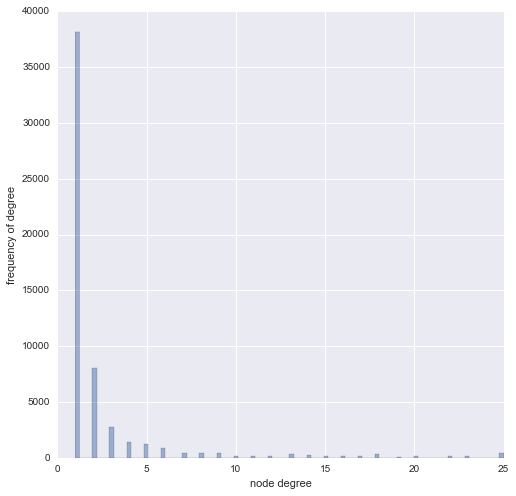

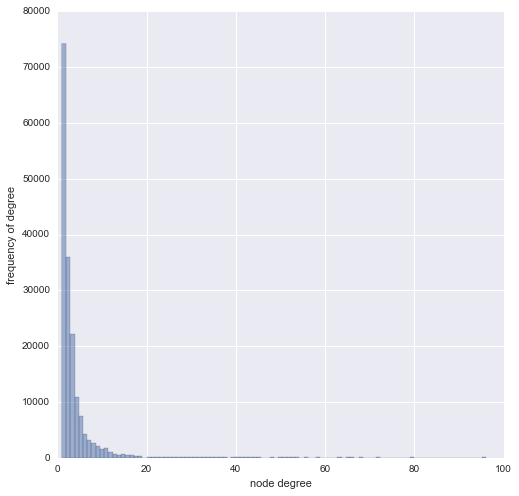

In [35]:
list_columns = K.columns.tolist()

list_control=[]
for row in K['Sample'].tolist():
    if row.split("_")[0] in ['H','K']:
        list_control.append(row)
list_columns.remove('Sample')  

df_control = K[K['Sample'].isin(list_control)]
df_antibiotics = K[~K['Sample'].isin(list_control)]
print df_control.shape
print df_antibiotics.shape



name_file = {0:"Control", 1:"Antibiotic"}
list_dfs = [df_control,df_antibiotics]
for df_index in range(len(list_dfs)):
    
    fname = name_file[df_index]
    df = list_dfs[df_index]
    M = df.as_matrix(list_columns)
    M_normalized = M.tolist()
    Matrix = []
    name_samples = df['Sample'].tolist()
    htb_samples = {}
    counter_row = 0
    for row in M_normalized:
        binarized_row = [int(bool(i)) for i in row]
        index_samples = [index for index,val in enumerate(binarized_row) if val==1]
        for otu_index in index_samples:
            x = list_columns[otu_index]
            if x in htb_samples:
                htb_samples[x].append(name_samples[counter_row])
            else:
                htb_samples[x]= [name_samples[counter_row]]
#         if index_samples ==[]:
#             htb_samples = []
        counter_row+=1
        Matrix.append(binarized_row)

    Matrix = np.asmatrix(Matrix)  
    print Matrix.sum(), Matrix.max(), Matrix.min()
    print Matrix.shape
    Matrix.view()

    Network = np.dot(Matrix.transpose(),Matrix)
    print Network.shape, Network.max(), Network.min()
    Network2 = np.asmatrix(Network, dtype=int)
    print Network2.shape
    print type(Network2)
    Network2.view()
    Network2 = Network2.tolist()


    #histogram of weighted degrees in the network
    degrees = []
    for row in Network2:
        for col in row:
            if col>0:
                degrees.append(col)

    plt.figure(figsize=(8,8))
    plt.hist(degrees, bins=100, alpha=0.5) 
    plt.xlabel('node degree')
    plt.ylabel('frequency of degree')


    G = nx.Graph()
    fout_n =open('network_or_otus_numberof_samples_%s.txt' % fname, 'wb')
    for row in range(len(Network2)):
        for col in range(len(Network2[row])): #these are the otus
            if row != col:                        
                u = list_columns[row]
                v = list_columns[col]

                if u in htb_samples: u_samples = list(htb_samples[u])
                else: u_samples = []
                if v in htb_samples: v_samples = list(htb_samples[v])
                else: v_samples = []
                intersection_tmp = list(set(u_samples) & set(v_samples))
                intersection = list(set([i.split("_")[0] for i in intersection_tmp]))

                #value = Network2[row][col] #This is the co occurence among all samples and time points independently

                value = len(intersection)
                if value >= threshold_number_occur_samples:
                    fout_n.write("%s\t%s\t%s\n" %(u,v, value) )                
                    fout_n.flush()
                    add_to_graph(G, u,v,value,u_samples,v_samples)

    fout_n.close()
    nx.write_gml(G,"network_%s.gml" %fname)
    print "Done with Koala Network for %s!!" %fname


In [ ]:
def add_treatment(row, htb):
    if float(row['Sample'].split("_")[1]) <2:
        return 'Control'
    return htb[row['Sample'].split("_")[0]]
        
K['treatment'] = K.apply(lambda row : add_treatment(row,htb_koala_all_timepoints), axis = 1)

In [ ]:
### Make sure the treatments that we have are either control group or antibiotic group (C,CE)
print set(K['treatment'])

In [ ]:
### Create
antibiotic_htb = {
    'C':1 ,
    'CE':1 ,
    'Control':0
}

K['Antibiotic'] = K.apply(lambda row : antibiotic_htb[row.treatment], axis = 1)

In [ ]:
K.head(5)

In [ ]:
K_t_a = K.copy()

In [ ]:
K_t_a.head(10)

In [ ]:
K_antibiotics = K[K.treatment != 'Control']

In [ ]:
# def add_fate(row, htb):
#     name = str(row['Sample'].split('_')[0])
#     return htb[name]


def add_fate(row,htb):
    return htb[str(row['Sample'])]
    
K_antibiotics['fate'] = K_antibiotics.apply(lambda row : add_fate(row,fate_koala_all_timepoints), axis = 1)

K_antibiotics.head()

In [ ]:
K_antibiotics.to_csv("K_antibiotics.csv", delimit="\t")

In [ ]:
list_treatment_c = []
list_treatment_ce = []
for j in K_antibiotics.treatment:
    if str(j)=='C':
        list_treatment_c.append(1)
        list_treatment_ce.append(0)
    else:
        list_treatment_c.append(0)
        list_treatment_ce.append(1)
        
        
#K_antibiotics['antibiotics_c'] = list_treatment_c
#K_antibiotics['antibiotics_ce'] = list_treatment_ce
K_antibiotics.head(8)                                                     

In [ ]:
K_antibiotics.drop(['treatment','Antibiotic'], axis=1, inplace=True)

In [ ]:
# correlations = K_antibiotics[1:].corr() ;
# plt.figure(figsize=(10,10))
# #g = sns.clustermap(correlations,method='complete', metric='correlation')
# sns.heatmap(correlations)
# plt.xticks(rotation=45);

In [ ]:
K_antibiotics.tail(20)

In [ ]:
yy = K_antibiotics['fate']
K_antibiotics.drop(['Sample','fate'], axis=1, inplace=True)
XX = K_antibiotics

In [ ]:
from sklearn.cross_validation import KFold
import sklearn.cross_validation as cv
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import roc_auc_score,classification_report
from treeinterpreter import treeinterpreter as ti
import sklearn.pipeline
import sklearn.cross_validation

def machine_learning(X,y):
    #First lets split the data into training and testing
    X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(X, y, test_size=0.25, random_state=0)
    kf = KFold(y_train.shape[0], 4, shuffle=True)

    #Logistic Regression
    lr = sklearn.linear_model.LogisticRegression(random_state=0,penalty='l2', C=0.1141)
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X)

    tmp = cv.cross_val_score(lr, X, y, cv=kf)
    print "Logistic Regression, mean= %s and std = %s from cross validations."%(tmp.mean(), tmp.std() )
    print "Logistic Regression Accuracy of test_data:%s, all_data:%s and train_data:%s\n\n" %(lr.score(X_test,y_test), lr.score(X,y), lr.score(X_train,y_train))


    #Random Forest
    RF_model = RandomForestClassifier(n_estimators = 100, oob_score = True, random_state=42, n_jobs = 8, max_features= 'log2',
                                      max_depth=7, min_samples_leaf=3, class_weight="balanced")
    RF_model.fit(X_train, y_train)
    y_pred_RF = RF_model.predict(X)
    tmp_RF = cv.cross_val_score(RF_model, X, y, cv=kf)
    print "Random Forest, mean= %s and std = %s from cross validations."%(tmp_RF.mean(), tmp_RF.std() )
    print "Random Forest  Accuracy of test_data:%s, all_data:%s and train_data:%s\n\n" %( RF_model.score(X_test,y_test), RF_model.score(X,y), RF_model.score(X_train,y_train) )
    return RF_model,lr,tmp_RF.mean()


In [ ]:
RF_model_fate,lr_fate,cross_valid_RF_fate = machine_learning(XX,yy)

In [ ]:
lr_fate.coef_

In [ ]:
# import pysurvey
# plt.figure(figsize=(16,16))
# tmp = lr_fate.coef_[0]
# ii = np.argsort(-tmp)
# plt.bar(left=np.arange(tmp.size)+0.1, width=0.8, height=tmp[ii])
# for i,(item, val) in enumerate(zip([XX.columns[j] for j in ii], tmp[ii])):
#     t = plt.text(i+0.5, 0.1, '{}: {:0.2f}'.format(item,val), rotation=90, ha='center', va='bottom' , size = 14)

In [ ]:
what_features_fate =pd.DataFrame(RF_model_fate.feature_importances_)
col = pd.DataFrame(XX.columns)
what_features_fate = pd.concat([what_features_fate, col], axis=1)
what_features_fate.columns = ['value','name']
#what_features_fate= what_features_fate[what_features_fate.value>0.015]
what_features_fate.sort_values(by='value')
None

In [ ]:
plt.figure(figsize=(15,7))
what_features_fate = what_features_fate[what_features_fate.value>0.000]
importance = what_features_fate['value']
plt.hist(importance, bins=40, alpha=0.5) ;
plt.title("Frequency of feature importances")


In [ ]:
htb_taxonomy = {}
with open("/Users/Lily/Desktop/Koala/taxonomy.txt", "rb") as f:
    #count = 0
    for line in f:
        arr= line.strip().split("\t")
        htb_taxonomy[arr[0]] = "\t".join(arr[1:])
#        count +=1
f.close()
print len(htb_taxonomy)
# for i in good_microbes:
#     print htb_taxonomy[i]

In [ ]:

what_features_fate = what_features_fate[what_features_fate['value']> 0]
print what_features_fate.shape
sorted_what_features_fate = what_features_fate.sort_values(by='value',ascending=False) #.sort(['value']) #.groupby('name').head()
top_percent = int(what_features_fate.shape[0]/100.0 * threshold)
what_features_fate = sorted_what_features_fate[:top_percent]
print what_features_fate.shape
# Microbes_fate = set(what_features_fate.name)
# print "len:",len(Microbes_fate), "--->", Microbes_fate, "\n\n"
# koala_microbes_fate = K[list((Microbes_fate)) + ['Sample','Antibiotic']]


# #koala_microbes_fate.plot(kind='area', figsize=(15,10), title = "abundance") ;
# # koala_good_microbes_original = Original[list(koala_microbes_fate)]
# # koala_good_microbes_original[11:22].plot(kind='area', figsize=(15,10), title = "abundance") ;
# koala_microbes_fate.head(10)

# koala_microbes_fate_w_antibiotic = koala_microbes_fate[koala_microbes_fate['Antibiotic']==1]
# print koala_microbes_fate_w_antibiotic.shape
# koala_microbes_fate_w_antibiotic.drop('Antibiotic', axis=1, inplace=True)
# koala_microbes_fate_w_antibiotic.plot(kind='area', figsize=(15,10), title = "abundance - Koalas with antibiotics") ;


# koala_microbes_fate_no_antibiotic = koala_microbes_fate[koala_microbes_fate['Antibiotic']==0]
# koala_microbes_fate_no_antibiotic.drop('Antibiotic', axis=1, inplace=True)
# print koala_microbes_fate_no_antibiotic.shape
# koala_microbes_fate_no_antibiotic.plot(kind='area', figsize=(15,10), title = "abundance - Kolalas No antibiotics") ;

In [ ]:
what_features_fate = what_features_fate.sort_values(by='value',ascending=False)
fateMicrobes_file = open("/Users/Lily/Desktop/Koala/microbes_important2fate_%s_RF_%s.txt" %("%.2f" %(cross_valid_RF_fate),top_percent), "wb")
for otu in what_features_fate.name:
    otu = str(otu)
    if otu.find('antibiotic') == -1:
        #print otu,OTUMapping_microbes[otu]
        arr = taxonomy_microbes[str(OTUMapping_microbes[otu])].split(";")
        fate_taxonomy = "\t".join([i.split("_")[-1] for i in arr] )
        #fateMicrobes_file.write("%s\t%s\n" %(OTUMapping_microbes[otu],fate_taxonomy) )
        fateMicrobes_file.write("%s\t%s\n" %(otu,fate_taxonomy) )
        #fateMicrobes_file.write("%s\n" %(otu) )
        fateMicrobes_file.flush()
fateMicrobes_file.close()

In [ ]:
print K.shape

K.head()

In [ ]:
print K.shape
K.head()

In [ ]:
print K_t_a.shape
K_t_a.tail()

In [ ]:
Koala.head()

In [ ]:
#K2 = Koala.copy()
#K2 = K2.reset_index()
#K2.rename(columns={'index':'Sample'}, inplace=True)

K2 = K_t_a
K2.head()

In [ ]:
list_columns = K.columns.tolist() #+ ['Sample']
print len(list_columns),"\n",list_columns[:5],"\n",list_columns[-5:]
K2 = K2[list_columns]
#K2['treatment'] = K2.apply(lambda row : add_treatment(row,htb_koala,name_koala), axis = 1)
K2.head()

In [ ]:
K.head(3)

In [ ]:
Original = K.copy()

In [ ]:
K.drop('treatment', axis=1, inplace=True)
# correlations = K.corr() ;
# sns.heatmap(correlations)
# plt.xticks(rotation=45);

In [ ]:
y = K['Antibiotic']
K.drop(['Antibiotic','Sample'], axis=1, inplace=True)
X = K

In [ ]:
print K.shape
K.head()

In [ ]:
def machine_learning2(X,y):
    #First lets split the data into training and testing
    X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(X, y, test_size=0.25, random_state=0)
    kf = KFold(y_train.shape[0], 2, shuffle=True)

    #Logistic Regression
    lr = sklearn.linear_model.LogisticRegression(random_state=0,penalty='l2', C=0.1141)
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X)

    tmp_lr = cv.cross_val_score(lr, X, y, cv=kf)
    print "Logistic Regression, mean= %s and std = %s from cross validations."%(tmp_lr.mean(), tmp_lr.std() )
    print "Logistic Regression Accuracy of test_data:%s, all_data:%s and train_data:%s\n\n" %(lr.score(X_test,y_test), lr.score(X,y), lr.score(X_train,y_train))
    LR_parameters = (lr,y_pred_lr,tmp_lr.mean())

    #Random Forest
    RF_model = RandomForestClassifier(n_estimators = 100, oob_score = True,  n_jobs = 8, max_features= 'log2',
                                      max_depth=7, min_samples_leaf=3, class_weight="balanced") #random_state=42,


    RF_model.fit(X_train, y_train)
    y_pred_RF = RF_model.predict(X)
    tmp_RF = cv.cross_val_score(RF_model, X, y, cv=kf)
    print "Random Forest, mean= %s and std = %s from cross validations."%(tmp_RF.mean(), tmp_RF.std() )
    print "Random Forest  Accuracy of test_data:%s, all_data:%s and train_data:%s\n\n" %( RF_model.score(X_test,y_test), RF_model.score(X,y), RF_model.score(X_train,y_train) )
    RF_parameters = (RF_model,y_pred_RF,tmp_RF.mean())
    
    #Gradient Boost
    GB_model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1)#, random_state=42)
    GB_model.fit(X_train, y_train)
    y_pred_GB = GB_model.predict(X)
    tmp_GB = cv.cross_val_score(GB_model, X, y, cv=kf)
    print "Gradient Boost, mean= %s and std = %s from cross validations."%(tmp_GB.mean(), tmp_GB.std() )
    print "Gradient Boost Accuracy of test_data:%s, all_data:%s and train_data:%s\n\n" %(GB_model.score(X_test, y_test) , GB_model.score(X,y), GB_model.score(X_train,y_train) )
    GB_parameters = (GB_model,y_pred_GB,tmp_GB.mean())
    
    return LR_parameters,RF_parameters,GB_parameters
    #    return RF_model,lr,y_pred_RF,tmp_RF.mean(),  GB_model,lr,y_pred_RF,tmp_RF.mean()


In [ ]:
LR_parameters,RF_parameters,GB_parameters = machine_learning2(X,y)

lr_antibiotic = LR_parameters[0]
y_pred_lr = LR_parameters[1]
cross_valid_lr_antibiotic = LR_parameters[2]


RF_model_antibiotic = RF_parameters[0]
y_pred_RF = RF_parameters[1]
cross_valid_RF_antibiotic = RF_parameters[2]

GB_model_antibiotic = GB_parameters[0]
y_pred_GB = GB_parameters[1]
cross_valid_GB_antibiotic = GB_parameters[2]


In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_curve, auc, precision_recall_curve
X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(X, y, test_size=0.25, random_state=0)
pipeline = make_pipeline(RF_model_antibiotic, lr_antibiotic)
pipeline.fit(X_train, y_train)
y_pred_rt = pipeline.predict_proba(X_test)[:, 1]
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_test, y_pred_rt)
auc_result = auc(fpr_rt_lm, tpr_rt_lm)
plt.plot(fpr_rt_lm, tpr_rt_lm)
plt.title('AUC: {:.3f}'.format(auc_result))
plt.ylabel('Sensitivity (True Positive rate)')
plt.xlabel('Specificity (False Positive rate)')


In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Oranges, fname=''):
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap,
               vmin=0, vmax=100)
    plt.title(title, fontsize=20)
    plt.colorbar(label='Percent')
    plt.grid('off')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)
    
    names = ['True Positive', 'False Positive', 
             'False Negative', 'True Negative']
    for i, (name, item) in enumerate(zip(names, cm.flatten())):
        tmp = plt.text(i//2, i%2, '{}\n{:0.2f}%'.format(name, item),
                 ha='center', va='center', fontsize=25)
    #plt.savefig('/Users/Lily/Desktop/aaa_alana_holy_final_positive_negative/confusion_matrix.png')
    plt.savefig('/Users/Lily/Desktop/Koala/confusion_matrix%s.png' %fname, transparent=True, bbox_inches='tight', pad_inches=3)

        
cm = sklearn.metrics.confusion_matrix(y, y_pred_RF)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100.0
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')


In [ ]:
# import pysurvey
# plt.figure(figsize=(50,50))
# tmp = lr_antibiotic.coef_[0]
# ii = np.argsort(-tmp)
# plt.bar(left=np.arange(tmp.size)+0.1, width=0.8, height=tmp[ii])
# for i,(item, val) in enumerate(zip([X.columns[j] for j in ii], tmp[ii])):
#     t = plt.text(i+0.5, 0.1, '{}: {:0.2f}'.format(item,val), rotation=90, ha='center', va='bottom' , size = 16)
# plt.xlabel("Important Features")
# plt.ylabel("feature Importance") ;

In [ ]:
print type(RF_model_antibiotic.feature_importances_)

In [ ]:
feature_importance_antibiotic =pd.DataFrame(RF_model_antibiotic.feature_importances_)
col = pd.DataFrame(X.columns)
what_features_antibiotics = pd.concat([feature_importance_antibiotic, col], axis=1)
what_features_antibiotics.columns = ['value','name']
what_features_antibiotics = what_features_antibiotics[what_features_antibiotics.value>0]
print what_features_antibiotics.shape
what_features_antibiotics.sort_values(by='value')
None

In [ ]:
#what_features_antibiotics['value'].sort_index().plot(kind='bar', figsize=(25,5)) ;
plt.figure(figsize=(15,7))
importance = what_features_antibiotics['value']
plt.hist(importance, bins=40, alpha=0.5) 
plt.title("Frequency of feature importances")


In [ ]:
what_features_antibiotics = what_features_antibiotics[what_features_antibiotics.value>0]
#what_features_antibiotics = what_features_antibiotics.sort_values(by='value',ascending=False)
print what_features_antibiotics.shape
sorted_what_features_antibiotics = what_features_antibiotics.sort_values(by='value',ascending=False)  #.sort(['value']) #.groupby('name').head()
top_percent = int(what_features_antibiotics.shape[0]/100.0 * threshold)
what_features_antibiotics = sorted_what_features_antibiotics[:top_percent]
print what_features_antibiotics.shape


print what_features_antibiotics.shape
what_features_antibiotics

In [ ]:
antibioticMicrobes_file = open("/Users/Lily/Desktop/Koala/microbes_important2antibiotic_%s_RF_%s.txt" %("%.2f"%cross_valid_RF_antibiotic,top_percent), "wb")
for otu in what_features_antibiotics.name:
    otu = str(otu)
    arr = taxonomy_microbes[str(OTUMapping_microbes[otu])].split(";")
    antibiotic_taxonomy = "\t".join([i.split("_")[-1] for i in arr] )
    #antibioticMicrobes_file.write("%s\t%s\n" %(OTUMapping_microbes[otu],antibiotic_taxonomy) )
    antibioticMicrobes_file.write("%s\t%s\n" %(otu,antibiotic_taxonomy) )
    antibioticMicrobes_file.flush()
antibioticMicrobes_file.close()

In [ ]:
OTUMapping_microbes['733']

In [ ]:
# from natsort import natsorted
# #antibio.sort('name')
# sorted_antibio = antibio.reindex(index=natsorted(antibio.name))
# sorted_antibio.drop(['Antibiotic','name'], axis=1, inplace=True)

In [ ]:
# sorted_antibiodd

In [ ]:
# T2_antibio.plot(kind='area', figsize=(15,10), title = "abundance for T2") ;

In [ ]:
fate_otus = what_features_fate.name.tolist()
antibiotic_otus = what_features_antibiotics.name.tolist()
hash_fate_otus = {i:1 for i in fate_otus}
otus_mutual = []
for i in antibiotic_otus:
    if i in hash_fate_otus:
        otus_mutual.append(i)

In [ ]:
print fate_otus
print "\n\n",antibiotic_otus
print "\n\n", otus_mutual

In [ ]:
#otus_mutual = ['New.ReferenceOTU97','New.ReferenceOTU93','New.ReferenceOTU91','New.ReferenceOTU90','New.ReferenceOTU9','New.ReferenceOTU88','New.ReferenceOTU83','New.ReferenceOTU74','New.ReferenceOTU73','New.ReferenceOTU62','New.ReferenceOTU52','New.ReferenceOTU509','New.ReferenceOTU500','New.ReferenceOTU497','New.ReferenceOTU481','New.ReferenceOTU469','New.ReferenceOTU461','New.ReferenceOTU431','New.ReferenceOTU424','New.ReferenceOTU423','New.ReferenceOTU40','New.ReferenceOTU383','New.ReferenceOTU360','New.ReferenceOTU359','New.ReferenceOTU357','New.ReferenceOTU337','New.ReferenceOTU336','New.ReferenceOTU335','New.ReferenceOTU304','New.ReferenceOTU27','New.ReferenceOTU249','New.ReferenceOTU247','New.ReferenceOTU241','New.ReferenceOTU236','New.ReferenceOTU235','New.ReferenceOTU232','New.ReferenceOTU19','New.ReferenceOTU165','New.ReferenceOTU164','New.ReferenceOTU159','New.ReferenceOTU136','New.ReferenceOTU126','New.ReferenceOTU116','New.ReferenceOTU0','New.CleanUp.ReferenceOTU73012','New.CleanUp.ReferenceOTU51807','New.CleanUp.ReferenceOTU285093','New.CleanUp.ReferenceOTU239119','New.CleanUp.ReferenceOTU186759','New.CleanUp.ReferenceOTU177146','New.CleanUp.ReferenceOTU107153','New.CleanUp.ReferenceOTU104941',953855,932696,922761,921522,869324,735609,696563,687940,589277,586290,585914,578649,578016,572889,548032,452014,4479397,4473977,4466618,4435875,4403261,4393208,3820075,364179,362997,359872,3483793,345353,342025,339417,328905,326662,323501,318599,303898,298592,297496,2656868,230403,230370,208843,2063400,195946,193591,144663,143423,142263,1111294,107450]

inv_map = {str(v): str(k) for k, v in OTUMapping_microbes.items()}
id_otus_mutual = [OTUMapping_microbes[str(i)] for i in otus_mutual]

In [ ]:
fout = open('/Users/Lily/Desktop/Koala/mutuals.txt',"wb")
for i in id_otus_mutual:
    fout.write('%s\t%s\n'%(inv_map[str(i)],taxonomy_microbes[str(i)]))
    #print i,taxonomy_microbes[str(i)],"\n" 
fout.close()

In [ ]:
def plot_stacked_otus(which_otus,koalas2keep,sorted_mutual_fate_antibio,OTUMapping_microbes,taxonomy_microbes):
    # define the colormap
    cmap = plt.cm.spectral_r
    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # force the first color entry to be grey
    cmaplist[-1] = (.5,.5,.5,1.0)
    # create the new map
    cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

    fig, axes = plt.subplots(nrows=4, ncols=3)
    fig.set_size_inches(25,25)
    rows = columns = counter = 0
    #axes = plt.gca()
    for i in koalas2keep:    

        if columns >2:
            columns %=3
            rows += 1

        #fig = plt.figure(figsize=(25,15))
        df_i = sorted_mutual_fate_antibio[sorted_mutual_fate_antibio['name']==i]
        df_i.drop(['name'], axis=1, inplace=True)
        ax1 = df_i.plot.bar(x='time', legend = False, stacked=True,ax=axes[rows, columns], 
                      xlim = [0,31], ylim=[0,10000], title= str(i) , cmap=cmap)

        #f.subplots_adjust(right=0.8)
        plt.title("%s"% (i) )
        #axes.set_ylim([0,1])
        #plt.savefig("/Users/Lily/Desktop/Koala/mutuals/%s.png" %i)
        #plt.close()
        print (rows, columns)
        columns +=1

    #None
    handles = df_i.columns.tolist()
    handles.remove('time')


    lines, labels = ax1.get_legend_handles_labels()
    labels = [taxonomy_microbes[OTUMapping_microbes[str(i)]].split(";")[taxonomy_level_integer:taxonomy_level_integer+1] for i in labels]

    plt.legend(lines, labels, loc=4) 
    #ax.legend(handles, labels)#, loc='right', fontsize=3,borderaxespad=0.)
    #plt.legend(loc='right', fontsize=3,borderaxespad=0.)
    #plt.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)
    plt.savefig("/Users/Lily/Desktop/Koala/All_%s.png" %str(which_otus) )

In [ ]:

from natsort import natsorted

name_file = {0:"Fate", 1:"Antibiotic",2:"Mutual"}

for which_otus in [fate_otus,antibiotic_otus,otus_mutual]:
    df_mutual_fate_antibiotic = Koala[which_otus] #fate_otus]# [antibiotic_otus] #Koala[otus_mutual]
    print df_mutual_fate_antibiotic.shape

    df_mutual_fate_antibiotic = df_mutual_fate_antibiotic.reset_index()
    df_mutual_fate_antibiotic.rename(columns={'index':'Sample'}, inplace=True)

    actual_names = []
    actual_times= []
    for i in df_mutual_fate_antibiotic.Sample.tolist():
        actual_names.append(i.split("_")[0])
        actual_times.append(float(i.split("_")[1]))
    df_mutual_fate_antibiotic['name'] = actual_names
    df_mutual_fate_antibiotic['time'] = actual_times


    df_mutual_fate_antibiotic.drop(['Sample'], axis=1, inplace=True)
    print df_mutual_fate_antibiotic.columns
    #antibio.sort('name')
    #sorted_mutual_fate_antibio = df_mutual_fate_antibiotic.reindex(index=natsorted(df_mutual_fate_antibiotic['Sample']))
    sorted_mutual_fate_antibio = df_mutual_fate_antibiotic.sort(['name','time']) #.groupby('name').head()
    #.apply(natsorted(df_mutual_fate_antibiotic.time))
    #sort_values(by='value',ascending=False)
    print sorted_mutual_fate_antibio.shape
    #sorted_mutual_fate_antibio.head(10)
    #df_mutual_fate_antibiotic.head()
    #Koala.head()
    fname = name_file[[fate_otus,antibiotic_otus,otus_mutual].index(which_otus)]
    plot_stacked_otus(fname,koalas2keep,sorted_mutual_fate_antibio,OTUMapping_microbes,taxonomy_microbes)

In [ ]:
"""
# define the colormap
cmap = plt.cm.spectral_r
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[-1] = (.5,.5,.5,1.0)
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
#fig, axes = plt.subplot()
fig, axes = plt.subplots(nrows=4, ncols=3)
fig.set_size_inches(25,25)
rows = columns = 0
#axes = plt.gca()
for i in koalas2keep:    
    if columns >2:
        columns %=3
        rows += 1

    #fig = plt.figure(figsize=(25,15))
    df_i = sorted_mutual_fate_antibio[sorted_mutual_fate_antibio['name']==i]
    df_i.drop(['name'], axis=1, inplace=True)
    df_i.plot.bar(x='time', legend = True, stacked=True,position=1,ax=axes[rows, columns], 
                  xlim = [0,31], ylim=[0,1],title= str(i) , cmap=cmap)
    
    #f.subplots_adjust(right=0.8)
    plt.title("%s"% (i) )
    #axes.set_ylim([0,1])
    #plt.savefig("/Users/Lily/Desktop/Koala/mutuals/%s.png" %i)
    #plt.close()
    print (rows, columns)
    columns +=1

#None
handles = df_i.columns.tolist()
handles.remove('time')
labels = [OTUMapping_microbes[i] for i in handles]


fig.legend(handles, labels, loc='right', fontsize=3,borderaxespad=0.)
#plt.legend(loc='right', fontsize=3,borderaxespad=0.)
#plt.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)
plt.savefig("/Users/Lily/Desktop/Koala/All.png")



"""